# Generative Adversarial Networks

Po raz pierwszy zaprezentowane w pracy "Generative Adversarial Nets" przez m.in Iana Goodfellowa (jednego z autorów książki "Deep learning" opisującej podsumowanie tego co się dzieje w deep learningu, w miarę aktualne). 

## O co chodzi?

<img src="gan_abstract.png">

> "Generative Adversarial Nets"
> -- <cite>[Goodfellow et al][1]</cite>

**Cel**: szukamy sposobu na *generowanie z rozkładu* $p$. 

Zakładamy istnienie pewnej zmiennej losowej $z$, która jest zmienną ukrytą o rozkładzie $p_Z(z)$. Zakładamy, że dane możemy przedstawić w postaci $G(z, \theta_G)$. Ponieważ do aproksymacji funkcji dobrze nadają się sieci neuronowe, będziemy przyjmowali, że $G$ jest wielowarstwowym perceptronem (tzw. feedforward neural network). Dodatkowo wprowadzamy klasyfikator $D$. Mając na wejściu pewne dane, klasyfikuje on czy powstały one z rzeczywistego czy symulowanego rozkładu (również będący siecią neuronową). D trenujemy żeby dobrze klasyfikował próbki z generatora. G trenujemy, żeby zminimalizować $\log(1 - D(G(z)))$ - innymi słowy, żeby dobrze oszukiwał on dyskryminator.

* Generator $G$
* Dyskryminator $D$

Rozważmy najpierw prosty, jednowymiarowy problem generowania z danej gęstości.

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt; plt.style.use('fivethirtyeight')
import seaborn as sns
import random
from tqdm.notebook import tqdm

# Setting random seeds
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)

$p(x) = x^{k-1}\frac{e^{-x/\theta}}{\theta^k\Gamma(k)}$

In [2]:
n = 100
x = np.random.gamma(3, 2, [100, 2])  # shape (k), scale (theta), size

## Implementacja generatora i dyskryminatora w PyTorchu

In [3]:
INPUT_DIM = 2
OUTPUT_DIM = 1
class GeneratorNet(torch.nn.Module):
    """Generator function - neural network with one hidden layer"""
    def __init__(self):
        super(GeneratorNet, self).__init__()
        self.hidden_dim = 5
        self.input_dim = INPUT_DIM
        self.out_dim = OUTPUT_DIM
        
        self.first_layer = nn.Sequential(
            nn.Linear(self.input_dim, self.hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out_layer = nn.Linear(self.hidden_dim, self.out_dim)

    def forward(self, x):
        x = self.first_layer(x)
        x = self.out_layer(x)
        return x

In [4]:
g_net = GeneratorNet()

In [5]:
z = torch.Tensor([1, 2])
g_net(z)

tensor([0.0467], grad_fn=<AddBackward0>)

In [6]:
class DiscriminatorNet(torch.nn.Module):
    """Disciriminator function - classification neural network with one hidden layer"""
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        self.hidden_dim = 5
        self.input_dim = OUTPUT_DIM
        self.out_dim = 1
        
        self.first_layer = nn.Sequential(
            nn.Linear(self.input_dim, self.hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out_layer = nn.Sequential(
            nn.Linear(self.hidden_dim, self.out_dim),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.first_layer(x)
        x = self.out_layer(x)
        return x

In [7]:
x = torch.Tensor([1])
d_net = DiscriminatorNet()
d_net(x)

tensor([0.6610], grad_fn=<SigmoidBackward>)

## Jak wytrenować te sieci?
### Stworzenie dyskryminatora i generatora

In [8]:
data_distribution = lambda : np.random.gamma(3, 2)  # "real" data distribution

def prior(n_samples = 1):
    return torch.randn([n_samples, 2])

# Creating generator and discriminator
generator = GeneratorNet()
discriminator = DiscriminatorNet()

Porównajmy teraz rozkład x oraz G(z). Zwróćmy uwagę, że naszym celem jest, żeby były one takie same (chociaż na razie żadna sieć nie została wytrenowana).

In [9]:
n = 10_000
data_sample = [data_distribution() for _ in range(n)]
gen_sample = [float(generator(prior())) for _ in range(n)]

Text(0.5, 1.0, 'Data distribution')

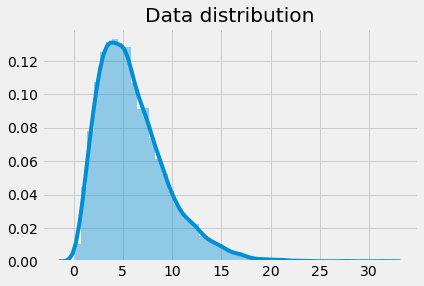

In [10]:
sns.distplot(data_sample).set_title("Data distribution")

Text(0.5, 1.0, 'Generator distribution')

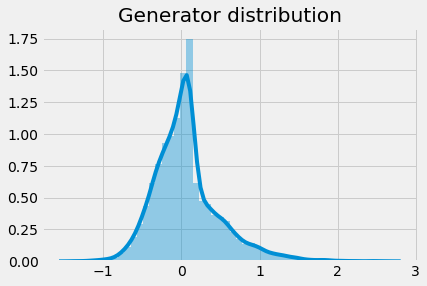

In [11]:
sns.distplot(gen_sample).set_title("Generator distribution")

Od razu widzimy, że bez treningu generator ma generuje ciekawy, raczej dość skomplikowany rozkład.

0.06393589699715375
[0.31367528438568115, 0.021308884024620056, -0.12793129682540894, 0.5266146659851074, -0.010389924049377441, -0.032502517104148865, 0.17128466069698334, 0.16905684769153595, 0.2643091082572937, -0.29415374994277954]


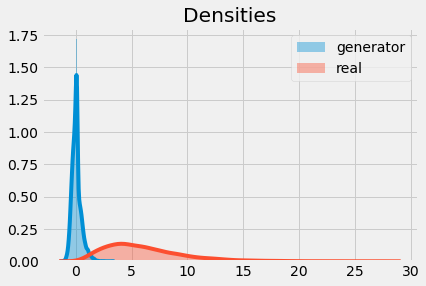

In [12]:
def plot_distributions(n=10_000):
    data_sample = [data_distribution() for _ in range(n)]
    gen_sample = [float(generator(prior())) for _ in range(n)]
    print(np.mean(gen_sample))
    print(gen_sample[:10])
    ax = sns.distplot(gen_sample, label="generator")
    sns.distplot(data_sample, label="real")
    ax.legend()
    ax.set_title("Densities")

plot_distributions()

Na chwilę obecną odróżnienie tych rozkładów nie jest trudne (zwłaszcza że jest to przypadek jednowymiarowy).

Text(0.5, 1.0, 'Discriminator values')

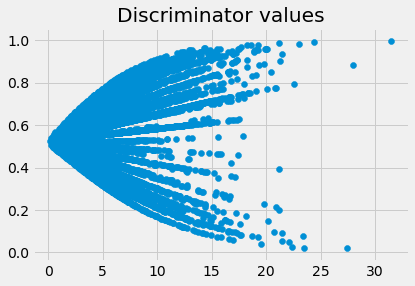

In [13]:
discriminator_values = [float(discriminator(torch.Tensor([x]))) for x in data_sample]
plt.scatter(data_sample, discriminator_values)
plt.title("Discriminator values")

Niewytrenowany dyskryminator jest często pewny swoich przewidywań (ale jego przewidywania są losowe).

Zastanówmy się jak do trenowania GANów podszedł Ian Goodfellow. Sformułował on zagadanienie teoretycznie, jako grę mini-maksową dwóch graczy (z value function V).

$\min_G \max_D \{V (D, G) = \mathbb{E}_{x \sim p_data(x)} (x) [log D(x)] +  \mathbb{E}_{x \sim p_Z(z)} [\log(1 − D(G(z)))]\}$

Tę optymalizację trzeba jednak jakoś wykonać w praktyce: "In practice, we must implement the game using an iterative, numerical
approach.".

Naturalnym sposobem na optymalizację jest na przemienne:
* przy ustalnonym $D$ maksymalizujemy $D(G(z))$ (lub równoważnie $\log [D(G(z))]$ względem $G$ dla $m$ przykładów z rozkładu a-priori
* przy ustalonym $G$ trenujemy klasyfikator $D$ na $m$ przykładach z danych i $m$ przykładach z generatora.

Powstaje pytanie jak maksymalizować D(G(z)) względem G. Z pozoru wygląda to na trudny problem (funkcja celu jest siecią neuronową), ale po chwili zastanowienia dochodzimy do wniosku, że ta funkcja niczym się nie różni od dowolnej innej (poza tym, że ma w sobie dużo parametrów, ale je znamy). Różniczkować sieci neuronowe umiemy (tym razem różniczkujemy D ze względu na argument, a nie parametry D, które są ustalone). Wobec tego jest to tylko złożenie funkcji i policzenie jej gradientu sprowadza się do liczenia gradientu funkcji złożonej.

$\frac{\partial}{\theta_G} D(G_{\theta}(z)) = J_D  \frac{\partial}{\theta_G} G_{\theta}(z) $,

gdzie $J_D$ jest jakobianem funkcji $D$.

Ostatecznie dochodzimy do następującego algorytmu zawartego w pracy Goodfellowa:

<img src="gan_algorithm.png">

> "Generative Adversarial Nets"
> -- <cite>[Goodfellow et al][1]</cite> 


Widoczna tam funkcja celu będąca sumą logarytmu z $D(x)$ i logarytmu z jeden minus $D(G(z)))$ jest standardową funkcją celu dla klasyfikacji binarnej - wiemy bowiem, że $x$ pochodzi z prawdziwego rozkładu, a $G(z)$ nie.

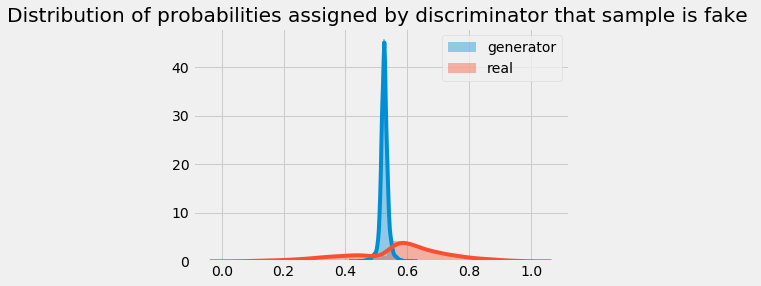

In [14]:
def plot_discriminator(n=10_000):
    discriminator_true = [float(discriminator(torch.Tensor([data_distribution()]))) for _ in range(n)]
    gen_values = [generator(prior()) for _ in range(n)]
    discriminator_gen = [float(discriminator(val)) for val in gen_values]
    ax = sns.distplot(discriminator_gen, label="generator")
    sns.distplot(discriminator_true, label="real")
    ax.legend()
    ax.set_title("Distribution of probabilities assigned by discriminator that sample is fake ")

plot_discriminator()

## Discriminator training

In [28]:
def train_discriminator(n_iter=31, m=10_000, lr=0.01, silent=False):

    optimizer = optim.Adam(discriminator.parameters(), lr=lr)

    discriminator.train()
    generator.eval()

    for _ in tqdm(range(n_iter)) if not silent else range(n_iter):
        ## Discriminator training
        # forward + backward + optimize

        optimizer.zero_grad()

        # randomly shuffling data before feeding into classifier
        inputs_list = [[data_distribution()] for _ in range(m)] + [[generator(prior())] for _ in range(m)]
        labels_list = [[0] for _ in range(m)] + [[1] for _ in range(m)]
        zipped = list(zip(inputs_list, labels_list))
        random.shuffle(zipped)
        inputs_list, labels_list = zip(*zipped)

        inputs = torch.tensor(inputs_list)
        labels = torch.tensor(labels_list).float()
        outputs = discriminator(inputs)
        loss = nn.BCEWithLogitsLoss()(outputs, labels)
        loss.backward()
        optimizer.step()

In [ ]:
train_discriminator()
plot_discriminator()

Wygląda na to, że dyskryminator jest się w stanie czegoś nauczyć i odróżnia prawdę od fałszu.

Text(0.5, 1.0, 'Discriminator values')

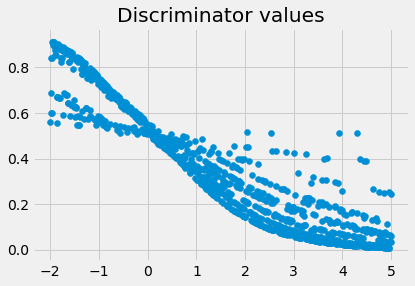

In [16]:
x_values = np.linspace(-2, 5, 1_000)
discriminator_values = [float(discriminator(torch.Tensor([x]))) for x in x_values]
plt.scatter(x_values, discriminator_values)
plt.title("Discriminator values")

Widzimy, że dyskryminator jest z grubsza malejącą funkcją. Im większa liczba tym bardziej zbliżona do próbki z rozkładu prawdziwego, a zatem mniejsza szansa na bycia fałszywą (wygenerowaną przez generator).

Skakanie między wartościami prawdopodobieństw może wskazywać na przeuczenie klasyfikatora.

## Generator training

In [29]:
def train_generator(n_iter=5_000, m=10_000, lr=1e-5, silent=False):
    optimizer = optim.Adam(generator.parameters(), lr=lr)

    generator.train()
    discriminator.eval()
    for _ in tqdm(range(n_iter)) if not silent else range(n_iter):
        optimizer.zero_grad()

        ## Generator training
        # forward + backward + optimize
        loss = torch.mean(torch.log(discriminator(generator(prior(m)))))
        loss.backward()
        optimizer.step()


3.775416557109356
[0.5056800842285156, 5.9864821434021, 2.9355225563049316, 3.3803863525390625, 8.294249534606934, 0.7984192371368408, 1.4008302688598633, 0.9480910897254944, 4.588692665100098, 8.74882698059082]


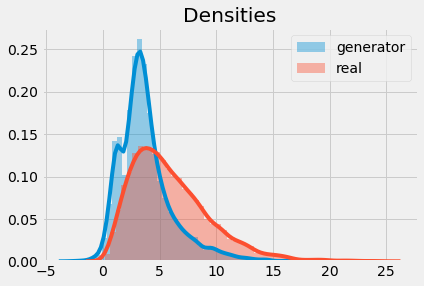

In [18]:
train_generator(n_iter=35_000, m=1_000, lr=2e-5)  # 40_000
plot_distributions()

## Discriminator - Generator training continued
Widzimy, że rozkład generatora znacznie przybliżył się do rozkładu rzeczywistego. Sprawdźmy jak teraz radzi sobie dyskryminator.

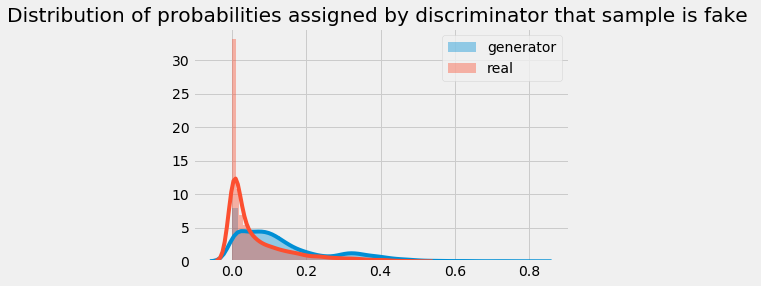

In [19]:
plot_discriminator()

Odpowiedź: dyskryminator radzi sobie gorzej. Już w tym momencie trudno mu odróżnić jeden od drugiego, do tego często jest bardzo niepewny wobec generatora. Wobec tego dalsze trenowanie generatora nie ma sensu: trzeba dotrenować dyskryminator, tym razem na trudniejszym przeciwniku. Dopóki nie douczymy dyskryminatora dalsze trenowanie generatora (mimo że to właśnie wytrenowanie generatora jest naszym celem) nie ma sensu.

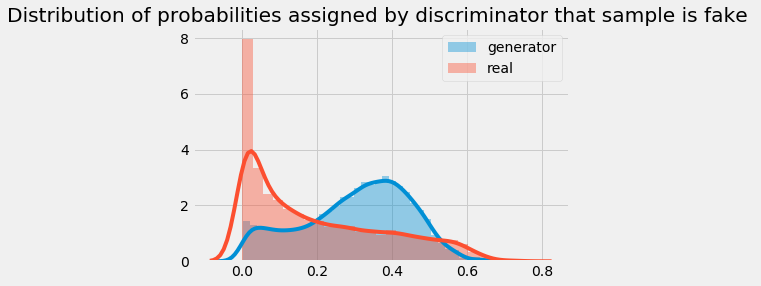

In [20]:
train_discriminator(n_iter=50, m=10_000, lr=0.01)  # zmniejszyc m do 1000
plot_discriminator()

Dobra nowina: dyskryminator zdołał trochę się douczyć i gęstość pstwa uznania rzeczywistych danych za fejk zmniejszyła się. Ale oczywiście siłą rzeczy trudno, żeby dyskryminator sobie dobrze radził: rozkłady po wytrenowaniu generatora pokrywają się w dużym stopniu (ich nośniki mają dużą część wspólną).

Dotrenujmy teraz generator.


5.675759655374288
[1.8212345838546753, 7.755788326263428, 2.9406416416168213, 7.0374298095703125, 4.575236797332764, 4.120512008666992, 6.153378486633301, 6.246058464050293, 0.1321476697921753, 4.328922748565674]


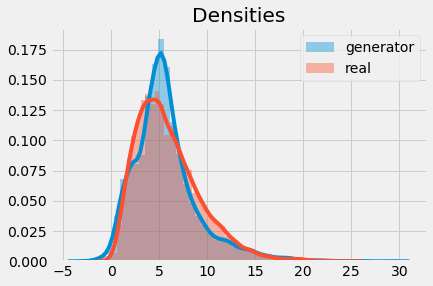

In [21]:
train_generator(n_iter=20_000, m=1_000, lr=1e-5)
plot_distributions()

Widzimy, że generator już może się świetnie dopasować do prawdziwego rozkładu. Cieszymy się z tego, chociaż w tym celu musieliśmy poświęcić trochę czasu. Zwróćmy za to uwagę, że pętlę zewnętrzną algorytmu Goodfellowa wykonaliśmy tylko dwa razy (ręcznie). Zwróćmy jednak na ciekawą rzecz (którą zaobserwowałem po dotrenowywaniu generatora zbyt długo). Dyskryminator (zgodnie z rozsądkiem) przyjmuję regułę, że jeżeli zmienne są zbyt małe, to oznacza to że zmienne są ze sfałszowanego rozkładu (bo taki rozkład generator przyjął na początku). Oznacza to jednak, że gdy będziemy generator trenowali zbyt długo, to "zauważy" on tę zależność i zacznie przyjmować dodatnie wartośći. Stąd konieczność stałego dotrenowywania dyskryminatora - w pewnym momencie może być on zmuszony do całkowitego zmienienia strategii - sieć będzie musiała się nauczyć zupełnie czegoś nowego.

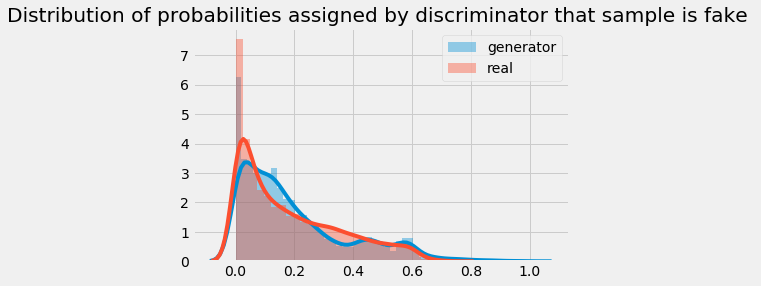

In [22]:
plot_discriminator()

Rzeczywiście, dyskryminator w tym momencie częściej oskarża o oszustwo próbki z prawdziwego rozkładu.


8.020373025542497
[16.672988891601562, 11.342145919799805, 7.472797393798828, 1.0829205513000488, 13.293743133544922, 2.2030553817749023, 9.253270149230957, 13.251047134399414, 14.01093864440918, 5.5905866622924805]


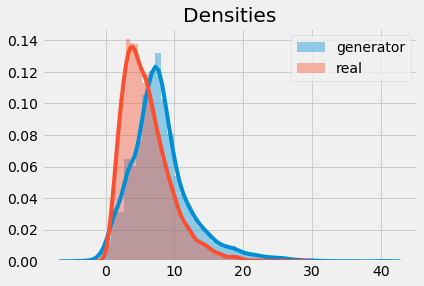

In [24]:
train_generator(n_iter=10_000, m=1_000, lr=2e-5)
plot_distributions()

Zaczynamy obserwować to, czego sie obawialiśmy - generator przyjmuje większe wartości od rzeczywistego rozkładu - dyskryminator jest zupełnie pogubiony. Pokazuje to dlaczego sztuka trenowania GANów jest taka trudna - bardzo trudno zachować równowagę między trenowaniem generatora i dyskryminatora, a dyskryminator nie może spocząć na laurach jeśli generator ma się ostatecznie czegokolwiek nauczyć. Gdy dyskryminator jest tak łatwo oszukowany ma dużo trudniej żeby się czegokolwiek nauczyć. Co więcej, gdyby pozwolić teraz generatorowi trenować się torchę dłużej to generowane przez niego wartości wybuchły by w nieskończoność.